# Лабораторная работа №3
### Выполнила Рындина Валерия, M33351

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

In [2]:
def normalize(data):
    for col in data.columns :
        if data[col].dtype.str == '<f8':
            min_val = min(data[col])
            max_val = max(data[col])
            data[col] = data[col].apply(lambda x: (x - min_val) / (max_val - min_val) if max_val != min_val else 0.0)

def get_data(file_path):
    data = pd.read_csv(file_path)
    normalize(data)
    data['class'] = data['class'].apply(lambda x: 1. if x == 'P' else -1.)

    return data

In [3]:
def get_cross_data(data):
    cross_data = []

    kf = KFold(n_splits=2, shuffle=True)
    for train_ind, test_ind in kf.split(data):
        get_x_y = lambda ind: (data.drop(columns='class').to_numpy()[ind], data['class'].to_numpy()[ind])
        x_train, y_train = get_x_y(train_ind)
        x_test, y_test = get_x_y(test_ind)

        cross_data.append((x_train, y_train, x_test, y_test))
    x, y = data.drop(columns='class').to_numpy(), data['class'].to_numpy()
    return x, y, cross_data

In [4]:
def polynomial_kernel(degree):
    def kernel(x, y):
        return np.dot(np.transpose(x), y) ** degree
    return kernel

linear_kernel = polynomial_kernel(1)

def gaussian_kernel(beta):
    def kernel(x, y):
        return np.exp(-beta * np.linalg.norm((x - y) ** 2))
    return kernel

In [14]:
from sklearn.metrics import accuracy_score
from statistics import median
from scipy.optimize import minimize

def get_fun(x, y, kernel):
    def fun(alfa):
        summa = 0
        for i in range(0, len(alfa)):
            for j in range(0, len(alfa)):
                summa += alfa[i] * alfa[j] * y[i] * y[j] * kernel(x[i], x[j])
        return - np.sum(alfa) + 1 / 2 * summa

    return fun

def get_w0(alfa, x, y, kernel):
    n, m = x.shape
    w = sum(alfa[i] * y[i] * x[i] for i in range(n))
    w0 = []
    for i in range(0, n):
        if alfa[i] > 0 and np.abs(y[i] * kernel(w, x[i]) - 1) < 0.01:
            w0 = np.append(w0, kernel(w, x[i]) - y[i])
    return median(w0) if len(w0) > 0 else 0

def get_classifier(alfa, w0, x, y, kernel):
    n, m = x.shape
    def fun(test_x):
        summa = sum(alfa[i] * y[i] * kernel(x[i], test_x) for i in range(n))
        return np.sign(summa - w0)
    return fun

def get_best_classifier(x_train, y_train, c, kernel):
    train_n, train_m = x_train.shape

    alfa0 = [0] * train_n
    bounds = [(0, c)] * train_n

    res = minimize(fun=get_fun(x_train, y_train, kernel),
                   x0=alfa0,
                   bounds=bounds,
                   constraints={'type': 'eq', 'fun': lambda alfa_: np.sum(alfa_ * y_train)},
                   options={'maxiter': 10})

    alfa = res.x
    w0 = get_w0(alfa, x_train, y_train, kernel)
    classifier = get_classifier(alfa, w0, x_train, y_train, kernel)

    return classifier, alfa, w0

def svm(cross_data, kernel):
    C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

    best_accuracy = -1.
    best_c = C[0]

    for c in C:
        sum_accuracy = 0
        for x_train, y_train, x_test, y_test in cross_data:
            cur_classifier, _, _ = get_best_classifier(x_train, y_train, c, kernel)

            sum_accuracy += accuracy_score(y_test, list(cur_classifier(x) for x in x_test), normalize=True)
        sum_accuracy = sum_accuracy / len(cross_data)
        print('c:', c, 'accuracy:', sum_accuracy)
        if sum_accuracy > best_accuracy:
            best_accuracy = sum_accuracy
            best_c = c
    return best_c, best_accuracy

In [6]:
from matplotlib import pyplot as plt

def draw_plot(title, ds, clf):
    plt.title(title)
    min_x1, max_x1 = np.min(ds[:, 0]), np.max(ds[:, 0])
    min_x2, max_x2 = np.min(ds[:, 1]), np.max(ds[:, 1])
    dx1 = max_x1 - min_x1
    dx2 = max_x2 - min_x2
    step1 = 10
    step2 = 60
    for x1 in np.arange(min_x1 - dx1 / step1, max_x1 + dx1 / step1, dx1 / step2):
        for x2 in np.arange(min_x2 - dx2 / step1, max_x2 + dx2 / step1, dx2 / step2):
            z = clf([x1, x2])
            c = 'w'
            c = 'lightcoral' if z == 1 else c
            c = 'lavenderblush' if z == -1 else c
            plt.scatter(x1, x2, color=c, s=150, marker='s')
    for i in range(len(ds)):
        features, label = ds[i][:-1], ds[i][-1]
        c = 'orchid' if label == -1 else 'red'
        plt.scatter(features[0], features[1], color=c, s=50)
    plt.show()

In [7]:
def get_best_classifier_linear(data, x, y, cross_data):
    c, accuracy = svm(cross_data, linear_kernel)
    print('best accuracy:', accuracy)
    print('best c:', c)
    classifier, alpha, w0 = get_best_classifier(x, y, c, linear_kernel)
    print('best alpha:', alpha)
    print('best w0:', w0)
    draw_plot('linear', data.to_numpy(), classifier)

c: 0.05 accuracy: 0.5847457627118644
c: 0.1 accuracy: 0.5169491525423728
c: 0.5 accuracy: 0.6016949152542372
c: 1.0 accuracy: 0.5169491525423728
c: 5.0 accuracy: 0.4491525423728814
c: 10.0 accuracy: 0.4745762711864407
c: 50.0 accuracy: 0.4152542372881356
c: 100.0 accuracy: 0.4152542372881356
best accuracy: 0.6016949152542372
best c: 0.5
best alpha: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.  0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.  0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
best w0: 0


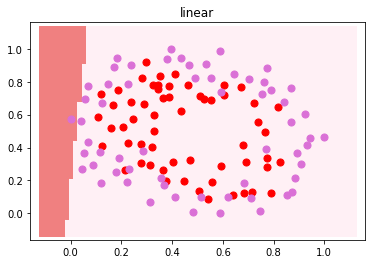

In [8]:
dt_chips = get_data('data/chips.csv')
x_chips, y_chips, cross_data_chips = get_cross_data(dt_chips)

get_best_classifier_linear(dt_chips, x_chips, y_chips, cross_data_chips)

c: 0.05 accuracy: 0.5847457627118644
c: 0.1 accuracy: 0.5254237288135593
c: 0.5 accuracy: 0.5847457627118644
c: 1.0 accuracy: 0.4915254237288136
c: 5.0 accuracy: 0.5847457627118644
c: 10.0 accuracy: 0.5847457627118644
c: 50.0 accuracy: 0.5084745762711864
c: 100.0 accuracy: 0.5847457627118644
n: 2 accuracy: 0.5847457627118644
c: 0.05 accuracy: 0.5084745762711864
c: 0.1 accuracy: 0.5508474576271186
c: 0.5 accuracy: 0.5847457627118644
c: 1.0 accuracy: 0.5847457627118644
c: 5.0 accuracy: 0.5254237288135593
c: 10.0 accuracy: 0.5677966101694916
c: 50.0 accuracy: 0.5593220338983051
c: 100.0 accuracy: 0.5932203389830508
n: 3 accuracy: 0.5932203389830508
c: 0.05 accuracy: 0.5508474576271186
c: 0.1 accuracy: 0.5932203389830508
c: 0.5 accuracy: 0.5593220338983051
c: 1.0 accuracy: 0.5423728813559322
c: 5.0 accuracy: 0.5508474576271186
c: 10.0 accuracy: 0.5593220338983051
c: 50.0 accuracy: 0.5508474576271186
c: 100.0 accuracy: 0.5593220338983051
n: 4 accuracy: 0.5932203389830508
c: 0.05 accuracy: 0

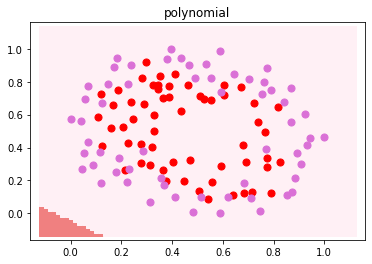

In [9]:
def get_best_classifier_polynomial(data, x, y, cross_data):
    best_n = 2
    best_c = 0.05
    best_accuracy = -1

    for n in [2, 3, 4, 5]:
        c, accuracy = svm(cross_data, polynomial_kernel(n))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_c = c
            best_n = n
        print('n:', n, 'accuracy:', accuracy)

    print('best accuracy:', best_accuracy)
    print('best n:', best_n)
    print('best c:', best_c)

    classifier, alpha, w0 = get_best_classifier(x, y, best_c, polynomial_kernel(best_n))
    print('best alpha:', alpha)
    print('best w0:', w0)
    draw_plot('polynomial', data.to_numpy(), classifier)

get_best_classifier_polynomial(dt_chips, x_chips, y_chips, cross_data_chips)

c: 0.05 accuracy: 0.4915254237288136
c: 0.1 accuracy: 0.4915254237288136
c: 0.5 accuracy: 0.4915254237288136
c: 1.0 accuracy: 0.4915254237288136
c: 5.0 accuracy: 0.4915254237288136
c: 10.0 accuracy: 0.4915254237288136
c: 50.0 accuracy: 0.5
c: 100.0 accuracy: 0.4915254237288136
beta: 1 accuracy: 0.5
c: 0.05 accuracy: 0.4915254237288136
c: 0.1 accuracy: 0.4915254237288136
c: 0.5 accuracy: 0.4915254237288136
c: 1.0 accuracy: 0.4915254237288136
c: 5.0 accuracy: 0.4915254237288136
c: 10.0 accuracy: 0.4915254237288136
c: 50.0 accuracy: 0.4915254237288136
c: 100.0 accuracy: 0.4915254237288136
beta: 2 accuracy: 0.4915254237288136
c: 0.05 accuracy: 0.5
c: 0.1 accuracy: 0.5
c: 0.5 accuracy: 0.5
c: 1.0 accuracy: 0.4915254237288136
c: 5.0 accuracy: 0.4915254237288136
c: 10.0 accuracy: 0.4915254237288136
c: 50.0 accuracy: 0.4915254237288136
c: 100.0 accuracy: 0.4915254237288136
beta: 3 accuracy: 0.5
c: 0.05 accuracy: 0.5084745762711864
c: 0.1 accuracy: 0.5084745762711864
c: 0.5 accuracy: 0.50847457

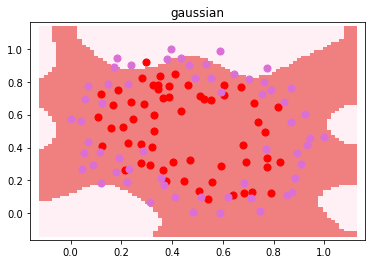

In [10]:
def get_best_classifier_gaussian(data, x, y, cross_data):
    best_beta = 1
    best_c = 0.05
    best_accuracy = -1

    for beta in [1, 2, 3, 4, 5]:
        c, accuracy = svm(cross_data, gaussian_kernel(beta))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_c = c
            best_beta = beta
        print('beta:', beta, 'accuracy:', accuracy)

    print('best accuracy:', best_accuracy)
    print('best beta:', best_beta)
    print('best c:', best_c)

    classifier, alpha, w0 = get_best_classifier(x, y, best_c, gaussian_kernel(best_beta))
    print('best alpha:', alpha)
    print('best w0:', w0)
    draw_plot('gaussian', data.to_numpy(), classifier)

get_best_classifier_gaussian(dt_chips, x_chips, y_chips, cross_data_chips)

c: 0.05 accuracy: 0.7117117117117118
c: 0.1 accuracy: 0.6981981981981982
c: 0.5 accuracy: 0.7027027027027026
c: 1.0 accuracy: 0.7387387387387387
c: 5.0 accuracy: 0.7117117117117118
c: 10.0 accuracy: 0.7117117117117118
c: 50.0 accuracy: 0.7072072072072072
c: 100.0 accuracy: 0.6981981981981982
best accuracy: 0.7387387387387387
best c: 1.0
best alpha: [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 4.74461342e-01
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.000000

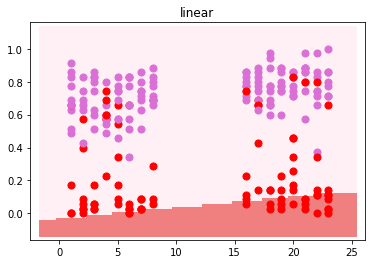

In [11]:
dt_geyser = get_data('data/geyser.csv')
x_geyser, y_geyser, cross_data_geyser = get_cross_data(dt_geyser)

get_best_classifier_linear(dt_geyser, x_geyser, y_geyser, cross_data_geyser)

c: 0.05 accuracy: 0.8693693693693694
c: 0.1 accuracy: 0.8693693693693694
c: 0.5 accuracy: 0.8423423423423424
c: 1.0 accuracy: 0.8423423423423424
c: 5.0 accuracy: 0.7072072072072072
c: 10.0 accuracy: 0.6576576576576576
c: 50.0 accuracy: 0.6621621621621622
c: 100.0 accuracy: 0.7612612612612613
n: 2 accuracy: 0.8693693693693694
c: 0.05 accuracy: 0.3963963963963964
c: 0.1 accuracy: 0.3963963963963964
c: 0.5 accuracy: 0.3963963963963964
c: 1.0 accuracy: 0.6216216216216216
c: 5.0 accuracy: 0.46396396396396394
c: 10.0 accuracy: 0.46396396396396394
c: 50.0 accuracy: 0.46396396396396394
c: 100.0 accuracy: 0.46396396396396394
n: 3 accuracy: 0.6216216216216216
c: 0.05 accuracy: 0.527027027027027
c: 0.1 accuracy: 0.6036036036036037
c: 0.5 accuracy: 0.6531531531531531
c: 1.0 accuracy: 0.46396396396396394
c: 5.0 accuracy: 0.5495495495495496
c: 10.0 accuracy: 0.7522522522522523
c: 50.0 accuracy: 0.5
c: 100.0 accuracy: 0.5585585585585586
n: 4 accuracy: 0.7522522522522523
c: 0.05 accuracy: 0.0
c: 0.1 a

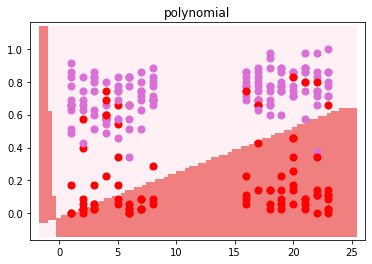

In [12]:
get_best_classifier_polynomial(dt_geyser, x_geyser, y_geyser, cross_data_geyser)

c: 0.05 accuracy: 0.7612612612612613
c: 0.1 accuracy: 0.7612612612612613
c: 0.5 accuracy: 0.7792792792792793
c: 1.0 accuracy: 0.8333333333333334
c: 5.0 accuracy: 0.8333333333333333
c: 10.0 accuracy: 0.8423423423423424
c: 50.0 accuracy: 0.6801801801801802
c: 100.0 accuracy: 0.6936936936936937
beta: 1 accuracy: 0.8423423423423424
c: 0.05 accuracy: 0.8063063063063063
c: 0.1 accuracy: 0.8063063063063063
c: 0.5 accuracy: 0.8153153153153153
c: 1.0 accuracy: 0.8603603603603605
c: 5.0 accuracy: 0.8738738738738738
c: 10.0 accuracy: 0.8603603603603605
c: 50.0 accuracy: 0.7252252252252251
c: 100.0 accuracy: 0.6396396396396397
beta: 2 accuracy: 0.8738738738738738
c: 0.05 accuracy: 0.8288288288288288
c: 0.1 accuracy: 0.8288288288288288
c: 0.5 accuracy: 0.8423423423423424
c: 1.0 accuracy: 0.8738738738738738
c: 5.0 accuracy: 0.8693693693693694
c: 10.0 accuracy: 0.8378378378378378
c: 50.0 accuracy: 0.6891891891891893
c: 100.0 accuracy: 0.5765765765765766
beta: 3 accuracy: 0.8738738738738738
c: 0.05 ac

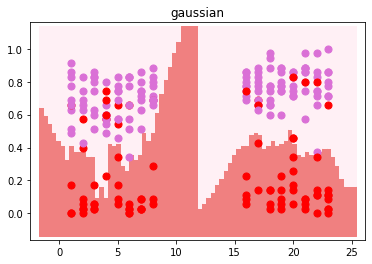

In [15]:
get_best_classifier_gaussian(dt_geyser, x_geyser, y_geyser, cross_data_geyser)